In [1]:
import itertools
import os
import random as rd
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px 
import plotly.graph_objects as go
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from pyriemann.estimation import Covariances
from pyriemann.utils import mean as riemann_mean
from pyriemann.utils import tangentspace
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from data import *
from model import *


def to_riemann_space(data):
    cov_matrices = Covariances().fit_transform(data)
    riemann_mean = mean_riemann(cov_matrices)
    tangent_space_data = tangent_space(cov_matrices, riemann_mean)
    return tangent_space_data, riemann_mean
def to_time_series(tangent_space_data, riemann_mean):
    cov_matrices = untangent_space(tangent_space_data, riemann_mean)
    return cov_matrices



def train(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    for batch_data, batch_targets in dataloader:
        batch_data = batch_data.to(device)
        batch_targets = batch_targets.to(device)

        optimizer.zero_grad()
        predictions = model(batch_data)
        loss = criterion(predictions, batch_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

class CustomFullyConnected(nn.Module):
    def __init__(self, n_ch, n_features, hidden_sizes, dropout=None):
        super(CustomFullyConnected, self).__init__()
        layers = []
        input_size = n_ch * n_ch
        self.n_ch = n_ch
        self.n_features = n_features 
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            if dropout:
                layers.append(nn.Dropout(p=dropout))
            input_size = hidden_size
            
        layers.append(nn.Linear(input_size, n_ch * n_features))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.network(x)
        x = x.view(x.size(0), self.n_ch, self.n_features)
        return x


In [2]:
df = np.load('xyz_acc.npy', allow_pickle =True) #np.load('series.npy', allow_pickle=True)
df = pd.DataFrame(df, columns = [str(i) for i in np.arange(2950)]+ ['Axis','UserID', 'Activity', 'Device'])
df.drop(df[(df.Device==1) & (df.UserID==1607) & (df.Activity=='J')].index[0], inplace = True)
df.drop(df[(df.Device==1) & (df.UserID==1609) & (df.Activity=='B')].index[0], inplace = True)
df.drop(df[(df.Device==1) & (df.UserID==1616) & (df.Activity=='F')].index[0], inplace = True)
df.drop(df[(df.Device==0) & (df.UserID==1637) & (df.Activity=='J')].index[0], inplace = True)
df.drop(df[(df.Device==0) & (df.UserID==1639) & (df.Activity=='L')].index[0], inplace = True)
df.drop(df[(df.Device==1) & (df.UserID==1643) & (df.Activity=='I')].index[0], inplace = True)

In [3]:
X_tensor = np.zeros((len(df.UserID.unique()) * len(df.UserID.unique()),3, 200 ))
index = 0
to_select = []
count = 0
for user in tqdm(df.UserID.unique()):
    for activity in df.Activity.unique():
            count += 1

            if df[(df.UserID==user) & (df.Activity==activity) &( df.Device==0)].shape[0]==3:
                to_select.append([user,activity])
                
                for axi_ind, axis in enumerate(['x','y','z']):
                
                    X_tensor[index,axi_ind,:] = (df[(df.UserID==user) & (df.Activity==activity) &( df.Axis==axis) &( df.Device==0) ].values[0][:200])
            
                index+=1



100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.44it/s]


In [4]:
N_EPOCHS = 300
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_FEATURES = 200
BATCH_SIZE = 512
HIDDEN_SIZES = [16, 64, 128, 256, 512]
DROPOUT = 0.5
LEARNING_RATE = 0.01
N_CH = 3


In [5]:
X_tensor, smart_indexes, watch_indexes = collect_data(df, N_FEATURES, N_CH)


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:19<00:00,  2.66it/s]


In [6]:

tangent_space_data_train, riemann_mean_train = to_riemann_space(X_tensor[:808*2,:,:])
reconstructed_data_train = to_time_series(tangent_space_data_train, riemann_mean_train)


cov_matrices = Covariances().fit_transform(X_tensor[808*2:908*2,:,:])
tangent_space_data_test = tangent_space(cov_matrices, riemann_mean_train)

reconstructed_data_test = untangent_space(tangent_space_data_test, riemann_mean_train)

In [7]:




n_ch = 3
train_loader = prepare_dataset(reconstructed_data_train, X_tensor, BATCH_SIZE)
model = CustomFullyConnected(n_ch=N_CH, n_features=N_FEATURES, hidden_sizes=HIDDEN_SIZES, dropout=DROPOUT).double().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [9]:

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, criterion, optimizer, DEVICE)
    print(f'Epoch {epoch+1}/{N_EPOCHS}, Loss: {train_loss:.6f}')

Epoch 1/300, Loss: 35.816990
Epoch 2/300, Loss: 36.090192
Epoch 3/300, Loss: 35.689407
Epoch 4/300, Loss: 35.350388
Epoch 5/300, Loss: 35.444905
Epoch 6/300, Loss: 34.747325
Epoch 7/300, Loss: 34.631106
Epoch 8/300, Loss: 34.754851
Epoch 9/300, Loss: 34.695924
Epoch 10/300, Loss: 34.454763
Epoch 11/300, Loss: 34.664946
Epoch 12/300, Loss: 34.492550
Epoch 13/300, Loss: 34.494339
Epoch 14/300, Loss: 34.123253
Epoch 15/300, Loss: 34.355651
Epoch 16/300, Loss: 33.936090
Epoch 17/300, Loss: 33.105839
Epoch 18/300, Loss: 33.484783
Epoch 19/300, Loss: 33.558323
Epoch 20/300, Loss: 33.011026
Epoch 21/300, Loss: 33.206365
Epoch 22/300, Loss: 32.760004
Epoch 23/300, Loss: 33.471738
Epoch 24/300, Loss: 32.713379
Epoch 25/300, Loss: 32.980619
Epoch 26/300, Loss: 33.034909
Epoch 27/300, Loss: 32.817634
Epoch 28/300, Loss: 32.697749
Epoch 29/300, Loss: 32.378127
Epoch 30/300, Loss: 32.531311
Epoch 31/300, Loss: 33.355230
Epoch 32/300, Loss: 32.325277
Epoch 33/300, Loss: 32.689912
Epoch 34/300, Loss:

Epoch 272/300, Loss: 31.354192
Epoch 273/300, Loss: 31.252015
Epoch 274/300, Loss: 30.792242
Epoch 275/300, Loss: 30.901366
Epoch 276/300, Loss: 31.484116
Epoch 277/300, Loss: 31.030307
Epoch 278/300, Loss: 30.770799
Epoch 279/300, Loss: 31.418308
Epoch 280/300, Loss: 31.156792
Epoch 281/300, Loss: 31.305276
Epoch 282/300, Loss: 30.538436
Epoch 283/300, Loss: 31.302025
Epoch 284/300, Loss: 31.084233
Epoch 285/300, Loss: 30.980405
Epoch 286/300, Loss: 30.858851
Epoch 287/300, Loss: 31.401697
Epoch 288/300, Loss: 31.006511
Epoch 289/300, Loss: 30.612881
Epoch 290/300, Loss: 31.119764
Epoch 291/300, Loss: 31.063066
Epoch 292/300, Loss: 31.111399
Epoch 293/300, Loss: 30.496587
Epoch 294/300, Loss: 31.379462
Epoch 295/300, Loss: 30.962372
Epoch 296/300, Loss: 31.083153
Epoch 297/300, Loss: 30.409611
Epoch 298/300, Loss: 30.387089
Epoch 299/300, Loss: 30.814353
Epoch 300/300, Loss: 30.943493


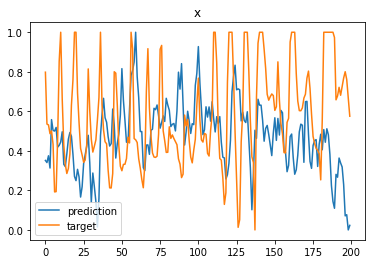

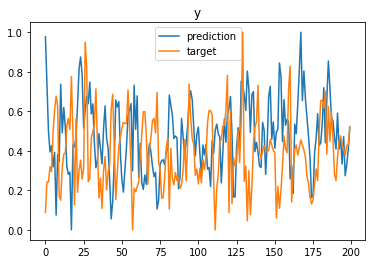

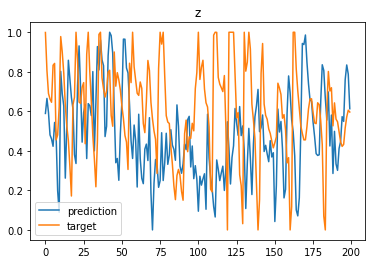

In [12]:
target_series = 12

prediction = get_predictions(model, target_series, reconstructed_data_test, DEVICE)

target = X_tensor[808*2:908*2,:,:][target_series+1]
plot_data(prediction, target)
